# COVID-19 - analysis and prediction  


### Table of Contents:  
1. [Checking the data](#Checking-the-data)
2. [Testing the data](#Testing-data)
3. [SVM](#SVM)
    - [Confirmed cases](#Confirmed-cases-SVM)
    - [Number of deaths](#Number-of-deaths-SVM)
    - [Number of recovered cases](#Number-of-recovered-cases-SVM)

## Checking the data
First, it is required to analyse our dataset so that it is sure to not have any problems. To do so, we will print the first entries of the dataset:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv('data/covid19.csv', parse_dates=['Date'], infer_datetime_format=True)
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


The first problem we can identify is that some entries don't have a value on the *Country/Region* column.

We can fix this by assigning the value 'NA' to those entries:

In [2]:
# filling missing values 
data[['Province/State']] = data[['Province/State']].fillna('')
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,,Angola,-11.2027,17.8739,2020-01-22,0,0,0


There were some comments on Kaggle about repeated lines, it seems this is not the case.

In [3]:
duplicated_rows = data.duplicated()
duplicated_rows[duplicated_rows == True]

Series([], dtype: bool)

We can now take a look at some summary statistics about the data set:

In [4]:
data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2430.562420,147.948752,607.899531
std,24.740912,70.570899,23545.664313,1561.525918,5210.234488
min,-51.796300,-135.000000,-1.000000,-1.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,184.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


We see that the count is the same for values in the columns *Lat*, *Long*, *Confirmed*, *Deaths* and *Recovered*.

There is, however, something strange with this dataset: The minimum value for *Confirmed* and *Deaths* is -1. Because negative values don't make sense for these two columns, we will use **mean imputation** to replace them with the average number for each column.

In [5]:
average_confirmed_count = data['Confirmed'].mean()
data.loc[(data['Confirmed'] < 0), 'Confirmed'] = average_confirmed_count

average_death_count = data['Deaths'].mean()
data.loc[(data['Deaths'] < 0), 'Deaths'] = average_death_count

data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2432.399240,148.055347,607.899531
std,24.740912,70.570899,23545.569393,1561.520830,5210.234488
min,-51.796300,-135.000000,0.000000,0.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,185.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


Now  those columns make more sense.

Also, to ensure data integrity, we will replace any missing values with 0s.

In [6]:
data[['Confirmed', 'Deaths', 'Recovered']] = data[['Confirmed', 'Deaths', 'Recovered']].fillna(0)

### Testing data

In [7]:
assert len(data.loc[(data['Deaths'] < 0)]) == 0

assert len(data.loc[(data['Confirmed'] < 0)]) == 0

assert len(data.loc[(data['Recovered'] < 0)]) == 0

It would be a shame to lose all this tidied up data. Let's save it.

In [8]:
data.to_csv('data/covid19_clean.csv', index=False)

We'll now take a look at the scatterplot matrix now that we've tidied the data:

In [9]:
data_clean = pd.read_csv('data/covid19_clean.csv')
data_clean.fillna(data_clean.mean(), inplace=True)
# sb.pairplot(data.dropna())

---

# SVM

In [10]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

number_days_predict = 15

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

train_days = np.array(epidemic_days[0:-number_days_predict]).reshape(-1, 1)
test_days = np.array(epidemic_days[-number_days_predict:]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

train_cases =  np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_cases = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

train_deaths = np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_deaths = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

train_recovered = np.array(world_recovered[0:-number_days_predict]).reshape(-1, 1)
test_recovered = np.array(world_recovered[-number_days_predict:]).reshape(-1, 1)

## Confirmed cases SVM

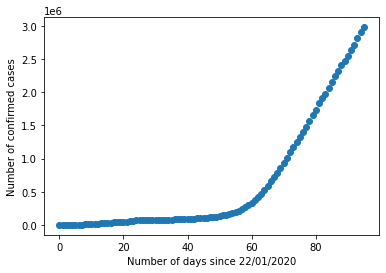

In [11]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

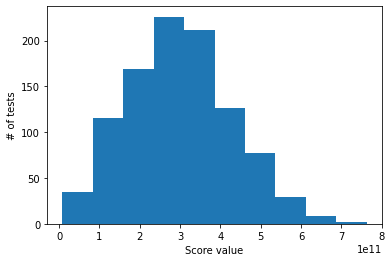

In [91]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_cases, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(mse_values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

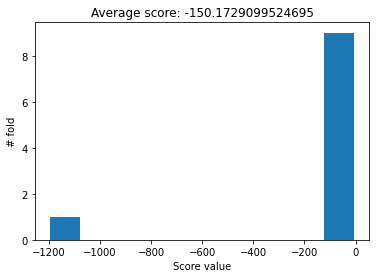

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_cases.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 6. After this we checked for the best combination for C and epsilon, and concluded that the lower the epsilon the better.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [179]:
from sklearn.model_selection import GridSearchCV

svm = SVR(kernel='poly', degree=6, tol=1e-6, epsilon=0.001)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 1.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_cases.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -61.32341118689503
Best parameters: {'C': 3.5, 'epsilon': 0.01}


In [44]:
svm_confirmed = grid_search.best_estimator_
print(svm_confirmed.get_params())

{'C': 1.0, 'cache_size': 200, 'coef0': 0.13122448979591836, 'degree': 6, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


In [ ]:
# To skip the slow grid search here is the SVR with the same parameters as above

svm_confirmed = SVR(C=1.0, cache_size=200, coef0=0.13122448979591836, degree=6, epsilon=0.001,
                    gamma='scale', kernel='poly', max_iter=-1, shrinking=True, tol=1e-6, verbose=False)

svm_confirmed.fit(train_days, train_cases.ravel())

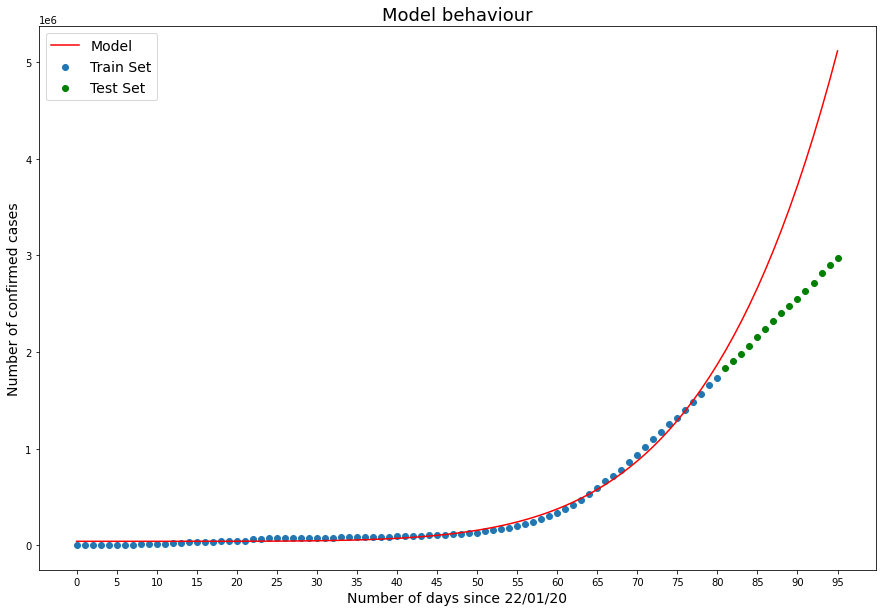

In [187]:
from sklearn.model_selection import cross_val_predict

pred_epi = svm_confirmed.predict(epidemic_days)
pred_test = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_cases, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_cases.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed.png')
plt.show()

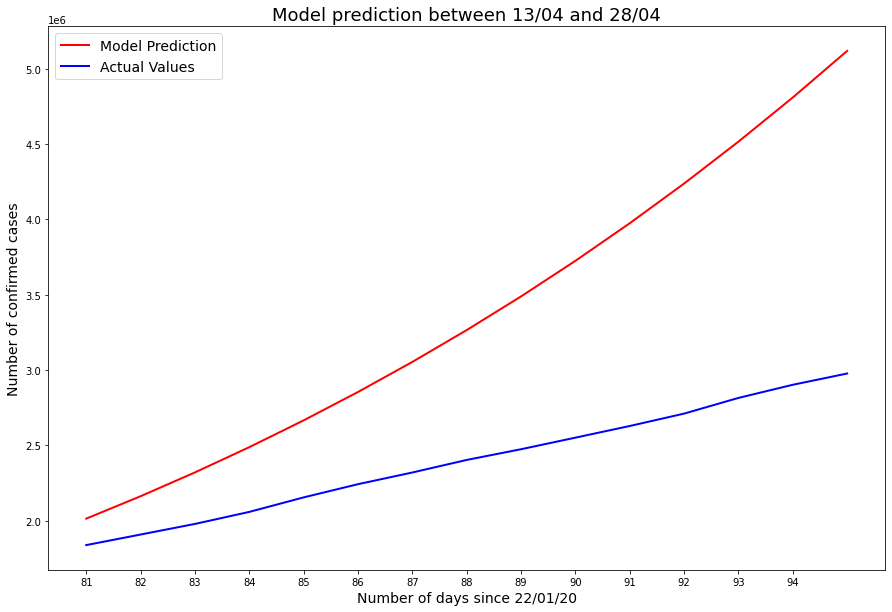

In [82]:
svr_pred_confirmed = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_confirmed, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_cases.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed_pred.png')
plt.show()

### Model statistics

In [87]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_cases, svr_pred_confirmed)
mae = mean_absolute_error(test_cases, svr_pred_confirmed)
mse = mean_squared_error(test_cases, svr_pred_confirmed)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		2142039.274
Mean Absolute Error: 	982382.836
Mean Squared Error: 	1332834514838.546


## Number of deaths SVM

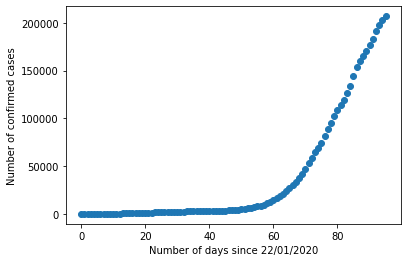

In [88]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

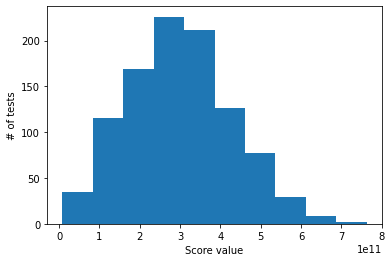

In [95]:
values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_deaths, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(mse_values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

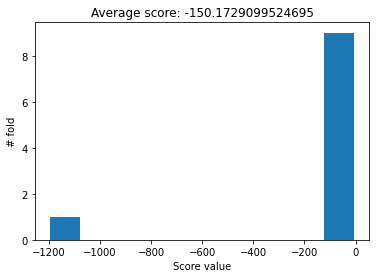

In [96]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_deaths.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 5. After this we checked for the best combination for C and epsilon, contrary to what happened in the confirmed cases model here the lower epsilon didnt result in better results.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [192]:
svm = SVR(kernel='poly', degree=5, tol=1e-6, epsilon=10)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_deaths.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -27.63768414640136
Best parameters: {'C': 39.5, 'coef0': 3.679795918367347}


In [196]:
svm_deaths = grid_search.best_estimator_
print(svm_deaths.get_params())

{'C': 39.5, 'cache_size': 200, 'coef0': 3.679795918367347, 'degree': 5, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


In [194]:
# To skip the slow grid search here is the SVR with the same parameters as above

svm_deaths = SVR(C=39.5, cache_size=200, coef0=3.679795918367347, degree=5, epsilon=10,
                   gamma='scale', kernel='poly', max_iter=-1, shrinking=True, tol=1e-6, verbose=False)

svm_deaths.fit(train_days, train_deaths.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=5, epsilon=0.8585714285714285,
    gamma='scale', kernel='poly', max_iter=-1, shrinking=True, tol=1e-06,
    verbose=False)

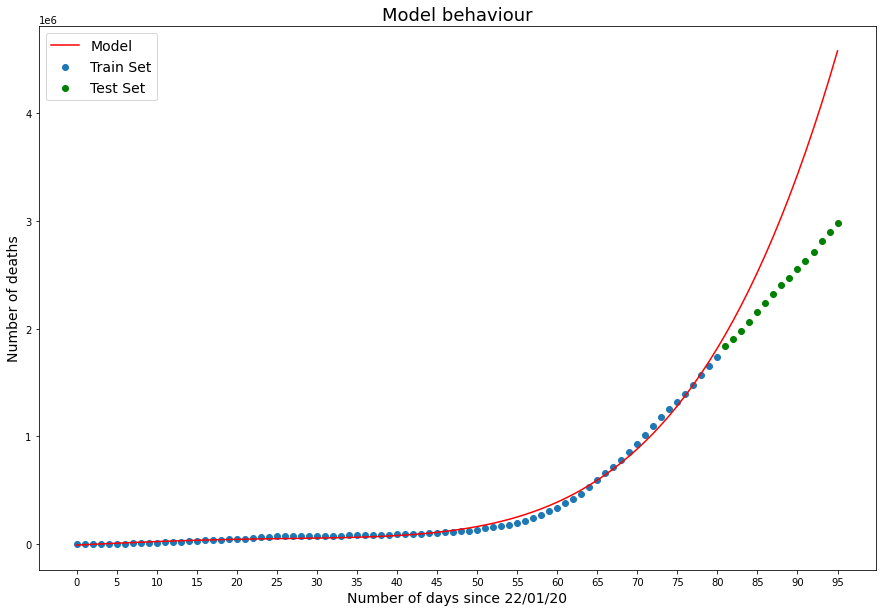

In [197]:
pred = svm_deaths.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_deaths, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_deaths.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_model.png')
plt.show()

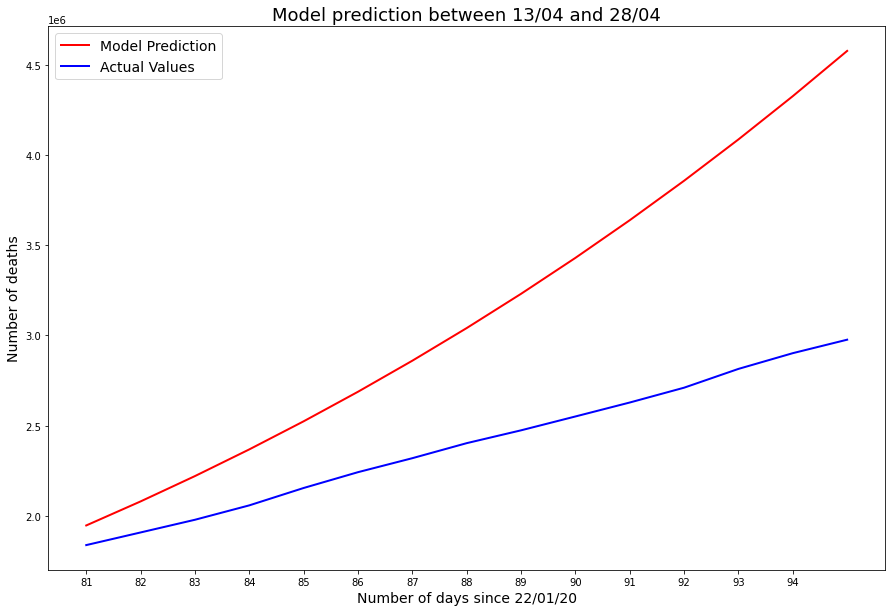

In [198]:
svr_pred_deaths = svm_deaths.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_deaths, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_deaths.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_pred.png')
plt.show()

### Model statistics

In [199]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_deaths, svr_pred_deaths)
mae = mean_absolute_error(test_deaths, svr_pred_deaths)
mse = mean_squared_error(test_deaths, svr_pred_deaths)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		1601655.943
Mean Absolute Error: 	728272.283
Mean Squared Error: 	742386552239.895


## Number of recovered cases SVM

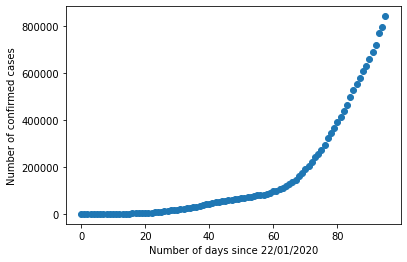

In [158]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

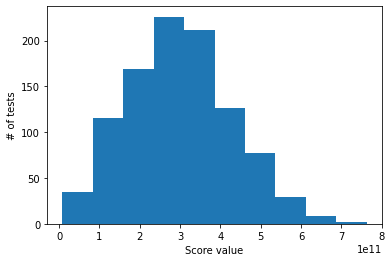

In [159]:
values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_recovered, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(mse_values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

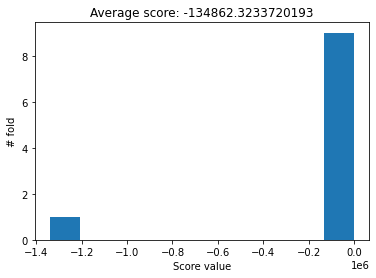

In [160]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_recovered.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 4. After this we checked for the best combination for C and epsilon. After this first test we noticed that the regression was well behaved, meaning it followed better the number of recoveries. We also noticed that the best value for epsilon was higher than the ones previously used.  
Since this model was well behaved the tests were quicker.

In [224]:
svm = SVR(kernel='poly', degree=4, tol=1e-6, C=32.5, epsilon=454)

parameter_grid = {'coef0': np.linspace(1.0, 2.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_recovered.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 29.986501064486408
Best parameters: {'coef0': 1.8571428571428572}


In [225]:
svm_recoveries = grid_search.best_estimator_
print(svm_recoveries.get_params())

{'C': 32.5, 'cache_size': 200, 'coef0': 1.8571428571428572, 'degree': 4, 'epsilon': 454, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


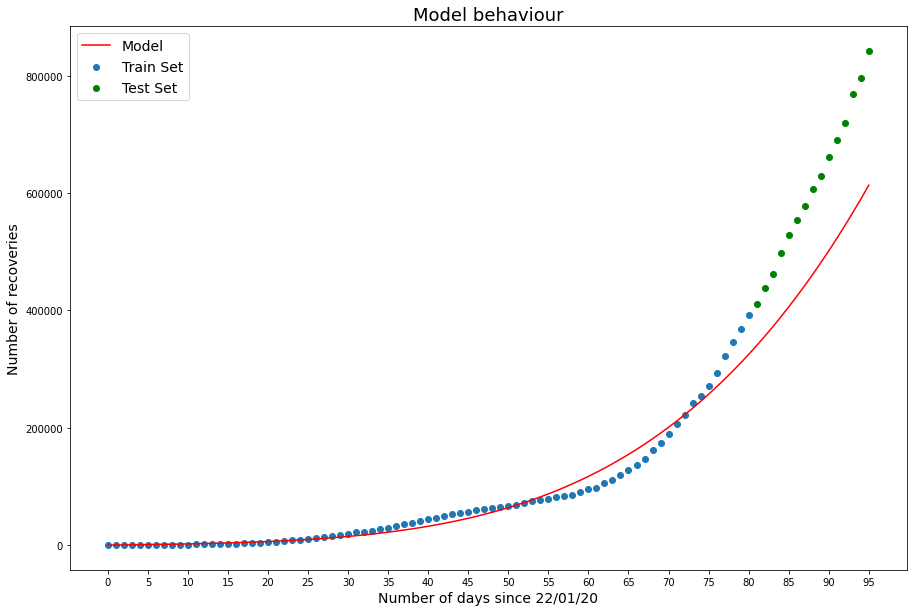

In [226]:
pred = svm_recoveries.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_recovered, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_recovered.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_model.png')
plt.show()

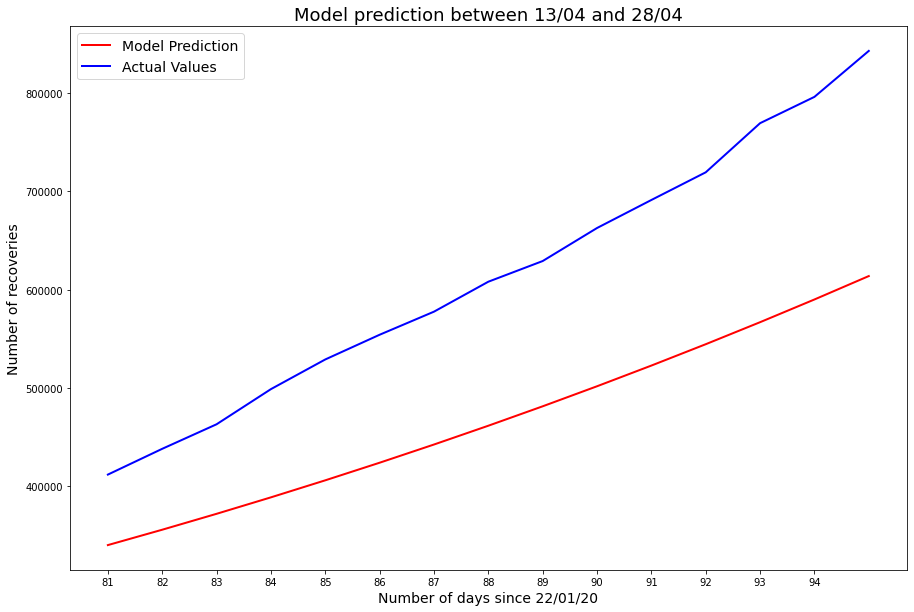

In [229]:
svr_pred_recoveries = svm_recoveries.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_recoveries, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_recovered.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_pred.png')
plt.show()

### Model statistics

In [228]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_recovered, svr_pred_recoveries)
mae = mean_absolute_error(test_recovered, svr_pred_recoveries)
mse = mean_squared_error(test_recovered, svr_pred_recoveries)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		229170.324
Mean Absolute Error: 	145387.601
Mean Squared Error: 	23142033248.139


# Neural Network

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [12]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

## Confirmed Cases

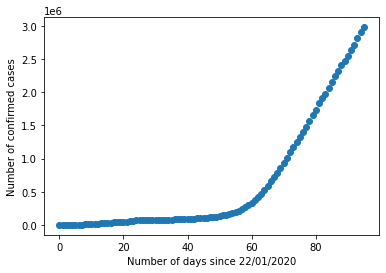

In [13]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

In [14]:
dp_world_cases = world_cases.astype('float32')

In [15]:
# split into train and test sets
train_size = int(len(dp_world_cases) * 0.67)
test_size = len(dp_world_cases) - train_size
train, test = dp_world_cases[0:train_size], dp_world_cases[train_size:len(dp_world_cases)]
print(len(train), len(test))

64 32


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [17]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_cases, look_back)
print(len(trainX))
print(len(testX))
print(len(testX)+len(trainX)+30)
print(len(finalX))
print(len(dp_world_cases))

48
16
94
81
96


In [18]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 791730798.5000
Epoch 2/1000
 - 0s - loss: 719866846.0000
Epoch 3/1000
 - 0s - loss: 693543176.6667
Epoch 4/1000
 - 0s - loss: 658359061.1667
Epoch 5/1000
 - 0s - loss: 646849121.6042
Epoch 6/1000
 - 0s - loss: 629212255.1667
Epoch 7/1000
 - 0s - loss: 580978439.6875
Epoch 8/1000
 - 0s - loss: 586555658.5000
Epoch 9/1000
 - 0s - loss: 553696672.3333
Epoch 10/1000
 - 0s - loss: 525750846.9167
Epoch 11/1000
 - 0s - loss: 500194990.1667
Epoch 12/1000
 - 0s - loss: 489690249.0000
Epoch 13/1000
 - 0s - loss: 467720235.0833
Epoch 14/1000
 - 0s - loss: 440147553.6667
Epoch 15/1000
 - 0s - loss: 426498675.5625
Epoch 16/1000
 - 0s - loss: 414204896.6667
Epoch 17/1000
 - 0s - loss: 411108827.2083
Epoch 18/1000
 - 0s - loss: 411349203.5833
Epoch 19/1000
 - 0s - loss: 386818734.8125
Epoch 20/1000
 - 0s - loss: 343180714.7917
Epoch 21/1000
 - 0s - loss: 342330613.8646
Epoch 22/1000
 - 0s - loss: 310011038.0833
Epoch 23/1000
 - 0s - loss: 301767368.2083
Epoch 24/1000
 - 0s 

 - 0s - loss: 34748413.7656
Epoch 193/1000
 - 0s - loss: 27282181.9766
Epoch 194/1000
 - 0s - loss: 27959142.7188
Epoch 195/1000
 - 0s - loss: 27301438.6927
Epoch 196/1000
 - 0s - loss: 21907227.9408
Epoch 197/1000
 - 0s - loss: 23502788.9427
Epoch 198/1000
 - 0s - loss: 21875569.6725
Epoch 199/1000
 - 0s - loss: 21587736.7552
Epoch 200/1000
 - 0s - loss: 23778681.8568
Epoch 201/1000
 - 0s - loss: 22348256.3438
Epoch 202/1000
 - 0s - loss: 24812501.6530
Epoch 203/1000
 - 0s - loss: 20679943.1328
Epoch 204/1000
 - 0s - loss: 23895912.5781
Epoch 205/1000
 - 0s - loss: 23566324.9635
Epoch 206/1000
 - 0s - loss: 22134080.1667
Epoch 207/1000
 - 0s - loss: 21661323.2656
Epoch 208/1000
 - 0s - loss: 24503363.0573
Epoch 209/1000
 - 0s - loss: 22839823.9844
Epoch 210/1000
 - 0s - loss: 22807378.3555
Epoch 211/1000
 - 0s - loss: 18288097.8021
Epoch 212/1000
 - 0s - loss: 23550365.4479
Epoch 213/1000
 - 0s - loss: 20236231.5531
Epoch 214/1000
 - 0s - loss: 19113812.0004
Epoch 215/1000
 - 0s - los

Epoch 383/1000
 - 0s - loss: 17686259.8932
Epoch 384/1000
 - 0s - loss: 16070732.6133
Epoch 385/1000
 - 0s - loss: 19767093.2240
Epoch 386/1000
 - 0s - loss: 15313050.1621
Epoch 387/1000
 - 0s - loss: 17434829.6309
Epoch 388/1000
 - 0s - loss: 20912262.2865
Epoch 389/1000
 - 0s - loss: 17859084.0729
Epoch 390/1000
 - 0s - loss: 17252020.3529
Epoch 391/1000
 - 0s - loss: 15054711.6222
Epoch 392/1000
 - 0s - loss: 14572824.9115
Epoch 393/1000
 - 0s - loss: 17316079.0807
Epoch 394/1000
 - 0s - loss: 15468865.5286
Epoch 395/1000
 - 0s - loss: 25293051.0326
Epoch 396/1000
 - 0s - loss: 19971292.8213
Epoch 397/1000
 - 0s - loss: 14436506.7852
Epoch 398/1000
 - 0s - loss: 34561135.3307
Epoch 399/1000
 - 0s - loss: 25968347.8255
Epoch 400/1000
 - 0s - loss: 14905937.9206
Epoch 401/1000
 - 0s - loss: 14858069.1533
Epoch 402/1000
 - 0s - loss: 14672527.8724
Epoch 403/1000
 - 0s - loss: 15786873.7578
Epoch 404/1000
 - 0s - loss: 16869336.3906
Epoch 405/1000
 - 0s - loss: 14793733.0625
Epoch 406/1

Epoch 574/1000
 - 0s - loss: 12978840.6849
Epoch 575/1000
 - 0s - loss: 13500406.8606
Epoch 576/1000
 - 0s - loss: 14200791.5892
Epoch 577/1000
 - 0s - loss: 14294155.2083
Epoch 578/1000
 - 0s - loss: 18588695.4388
Epoch 579/1000
 - 0s - loss: 25462037.5104
Epoch 580/1000
 - 0s - loss: 26348799.0575
Epoch 581/1000
 - 0s - loss: 22454473.8687
Epoch 582/1000
 - 0s - loss: 17140079.5537
Epoch 583/1000
 - 0s - loss: 13046057.9922
Epoch 584/1000
 - 0s - loss: 15769837.6634
Epoch 585/1000
 - 0s - loss: 13814466.6374
Epoch 586/1000
 - 0s - loss: 14125647.9961
Epoch 587/1000
 - 0s - loss: 12696702.9792
Epoch 588/1000
 - 0s - loss: 15314539.5723
Epoch 589/1000
 - 0s - loss: 18770440.1393
Epoch 590/1000
 - 0s - loss: 19322480.7552
Epoch 591/1000
 - 0s - loss: 16292373.5221
Epoch 592/1000
 - 0s - loss: 14150462.8182
Epoch 593/1000
 - 0s - loss: 13100412.7486
Epoch 594/1000
 - 0s - loss: 17020156.5039
Epoch 595/1000
 - 0s - loss: 14292000.7370
Epoch 596/1000
 - 0s - loss: 24552494.1263
Epoch 597/1

Epoch 765/1000
 - 0s - loss: 11839978.8066
Epoch 766/1000
 - 0s - loss: 12918453.1589
Epoch 767/1000
 - 0s - loss: 14104060.2699
Epoch 768/1000
 - 0s - loss: 15830927.8662
Epoch 769/1000
 - 0s - loss: 15904664.3945
Epoch 770/1000
 - 0s - loss: 12845135.6393
Epoch 771/1000
 - 0s - loss: 14046955.7982
Epoch 772/1000
 - 0s - loss: 14704332.9167
Epoch 773/1000
 - 0s - loss: 16978041.4219
Epoch 774/1000
 - 0s - loss: 11845186.3724
Epoch 775/1000
 - 0s - loss: 12474136.0589
Epoch 776/1000
 - 0s - loss: 13951202.5391
Epoch 777/1000
 - 0s - loss: 14728162.8214
Epoch 778/1000
 - 0s - loss: 16718432.5495
Epoch 779/1000
 - 0s - loss: 12617995.1897
Epoch 780/1000
 - 0s - loss: 13106677.9163
Epoch 781/1000
 - 0s - loss: 13987774.2357
Epoch 782/1000
 - 0s - loss: 12853616.7487
Epoch 783/1000
 - 0s - loss: 12864433.8747
Epoch 784/1000
 - 0s - loss: 15433097.1562
Epoch 785/1000
 - 0s - loss: 13248200.4753
Epoch 786/1000
 - 0s - loss: 12502013.3255
Epoch 787/1000
 - 0s - loss: 12338908.3855
Epoch 788/1

Epoch 956/1000
 - 0s - loss: 14250699.8480
Epoch 957/1000
 - 0s - loss: 13865150.5911
Epoch 958/1000
 - 0s - loss: 13071486.0091
Epoch 959/1000
 - 0s - loss: 11946810.6875
Epoch 960/1000
 - 0s - loss: 13262934.1628
Epoch 961/1000
 - 0s - loss: 15040542.4278
Epoch 962/1000
 - 0s - loss: 11866002.4492
Epoch 963/1000
 - 0s - loss: 11694200.1111
Epoch 964/1000
 - 0s - loss: 15996868.8880
Epoch 965/1000
 - 0s - loss: 11278499.2552
Epoch 966/1000
 - 0s - loss: 13839555.4326
Epoch 967/1000
 - 0s - loss: 13803955.3368
Epoch 968/1000
 - 0s - loss: 13122626.3496
Epoch 969/1000
 - 0s - loss: 14419298.4557
Epoch 970/1000
 - 0s - loss: 16771178.6829
Epoch 971/1000
 - 0s - loss: 11167689.3353
Epoch 972/1000
 - 0s - loss: 10636149.2669
Epoch 973/1000
 - 0s - loss: 13790095.0833
Epoch 974/1000
 - 0s - loss: 11982187.4924
Epoch 975/1000
 - 0s - loss: 12691607.9922
Epoch 976/1000
 - 0s - loss: 14242083.6797
Epoch 977/1000
 - 0s - loss: 13647720.0337
Epoch 978/1000
 - 0s - loss: 12780861.9115
Epoch 979/1

In [19]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 12037246.67 MSE (3469.47 RMSE)
Test Score: 1058886528.00 MSE (32540.54 RMSE)


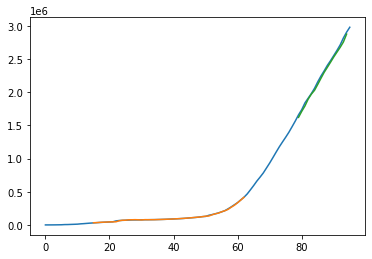

In [21]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_cases)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_cases)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_cases[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

In [23]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

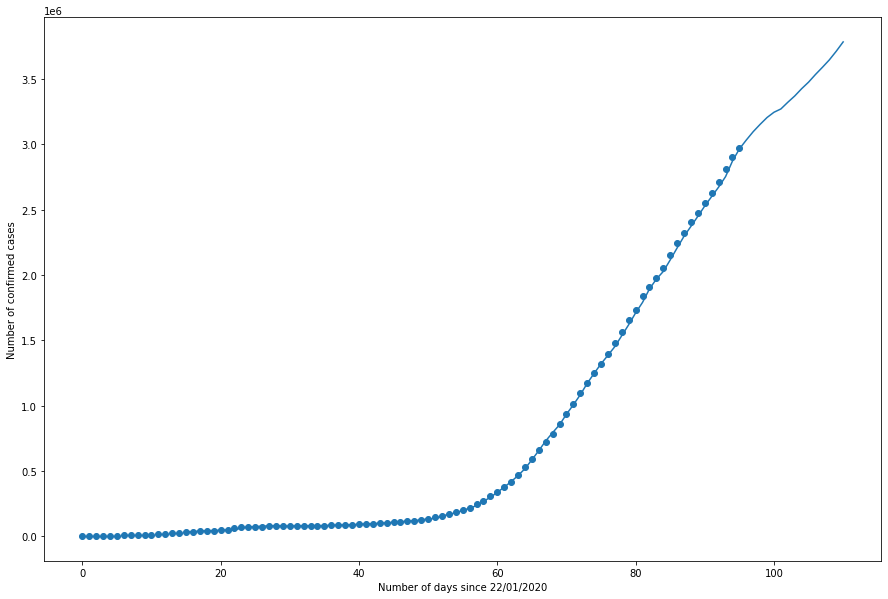

In [24]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.plot(allTest)
plt.show()

## Confirmed deaths

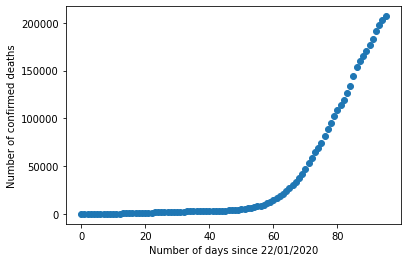

In [25]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed deaths')
plt.show()

In [26]:
dp_world_deaths = world_deaths.astype('float32')

In [27]:
# split into train and test sets
train_size = int(len(dp_world_deaths) * 0.67)
test_size = len(dp_world_deaths) - train_size
train, test = dp_world_deaths[0:train_size], dp_world_deaths[train_size:len(dp_world_deaths)]
print(len(train), len(test))

64 32


In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [32]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_deaths, look_back)
print(len(trainX))
print(len(testX))
print(len(testX)+len(trainX)+30)
print(len(finalX))
print(len(dp_world_deaths))

48
16
94
81
96


In [33]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 280718.3319
Epoch 2/1000
 - 0s - loss: 123583.3669
Epoch 3/1000
 - 0s - loss: 81478.5218
Epoch 4/1000
 - 0s - loss: 67392.4017
Epoch 5/1000
 - 0s - loss: 51750.1022
Epoch 6/1000
 - 0s - loss: 56164.6355
Epoch 7/1000
 - 0s - loss: 55576.0583
Epoch 8/1000
 - 0s - loss: 56498.8465
Epoch 9/1000
 - 0s - loss: 47742.2306
Epoch 10/1000
 - 0s - loss: 55510.6002
Epoch 11/1000
 - 0s - loss: 45073.2792
Epoch 12/1000
 - 0s - loss: 44579.8289
Epoch 13/1000
 - 0s - loss: 49347.5556
Epoch 14/1000
 - 0s - loss: 45823.5651
Epoch 15/1000
 - 0s - loss: 48182.8891
Epoch 16/1000
 - 0s - loss: 48858.6535
Epoch 17/1000
 - 0s - loss: 45811.2017
Epoch 18/1000
 - 0s - loss: 62744.7340
Epoch 19/1000
 - 0s - loss: 44147.6919
Epoch 20/1000
 - 0s - loss: 44556.1753
Epoch 21/1000
 - 0s - loss: 41684.9343
Epoch 22/1000
 - 0s - loss: 36885.0700
Epoch 23/1000
 - 0s - loss: 40924.2259
Epoch 24/1000
 - 0s - loss: 39452.9818
Epoch 25/1000
 - 0s - loss: 35235.1780
Epoch 26/1000
 - 0s - loss: 4609

Epoch 209/1000
 - 0s - loss: 9569.8617
Epoch 210/1000
 - 0s - loss: 10160.9151
Epoch 211/1000
 - 0s - loss: 17695.4517
Epoch 212/1000
 - 0s - loss: 18969.0404
Epoch 213/1000
 - 0s - loss: 9726.3281
Epoch 214/1000
 - 0s - loss: 9171.0387
Epoch 215/1000
 - 0s - loss: 11478.3141
Epoch 216/1000
 - 0s - loss: 8806.0977
Epoch 217/1000
 - 0s - loss: 8553.8357
Epoch 218/1000
 - 0s - loss: 17518.0596
Epoch 219/1000
 - 0s - loss: 14958.7566
Epoch 220/1000
 - 0s - loss: 9263.3933
Epoch 221/1000
 - 0s - loss: 8177.9417
Epoch 222/1000
 - 0s - loss: 9994.7527
Epoch 223/1000
 - 0s - loss: 10584.3734
Epoch 224/1000
 - 0s - loss: 7593.2751
Epoch 225/1000
 - 0s - loss: 20194.3681
Epoch 226/1000
 - 0s - loss: 21356.1781
Epoch 227/1000
 - 0s - loss: 11469.7942
Epoch 228/1000
 - 0s - loss: 16004.4596
Epoch 229/1000
 - 0s - loss: 17597.4761
Epoch 230/1000
 - 0s - loss: 11900.0928
Epoch 231/1000
 - 0s - loss: 18304.6545
Epoch 232/1000
 - 0s - loss: 12257.0910
Epoch 233/1000
 - 0s - loss: 12540.2440
Epoch 234

Epoch 416/1000
 - 0s - loss: 13145.7065
Epoch 417/1000
 - 0s - loss: 13402.3413
Epoch 418/1000
 - 0s - loss: 7825.4600
Epoch 419/1000
 - 0s - loss: 9021.6559
Epoch 420/1000
 - 0s - loss: 9234.7998
Epoch 421/1000
 - 0s - loss: 9048.9358
Epoch 422/1000
 - 0s - loss: 9017.7363
Epoch 423/1000
 - 0s - loss: 8168.9953
Epoch 424/1000
 - 0s - loss: 20161.9745
Epoch 425/1000
 - 0s - loss: 32767.4374
Epoch 426/1000
 - 0s - loss: 32822.3151
Epoch 427/1000
 - 0s - loss: 11347.9695
Epoch 428/1000
 - 0s - loss: 8709.8822
Epoch 429/1000
 - 0s - loss: 16444.0205
Epoch 430/1000
 - 0s - loss: 8428.6645
Epoch 431/1000
 - 0s - loss: 8860.8586
Epoch 432/1000
 - 0s - loss: 12552.7022
Epoch 433/1000
 - 0s - loss: 13453.8926
Epoch 434/1000
 - 0s - loss: 12607.6590
Epoch 435/1000
 - 0s - loss: 8113.1563
Epoch 436/1000
 - 0s - loss: 10014.6399
Epoch 437/1000
 - 0s - loss: 11903.9732
Epoch 438/1000
 - 0s - loss: 16608.2139
Epoch 439/1000
 - 0s - loss: 9639.9166
Epoch 440/1000
 - 0s - loss: 12853.7704
Epoch 441/1

Epoch 623/1000
 - 0s - loss: 9409.9960
Epoch 624/1000
 - 0s - loss: 9824.5340
Epoch 625/1000
 - 0s - loss: 25610.4165
Epoch 626/1000
 - 0s - loss: 13759.0095
Epoch 627/1000
 - 0s - loss: 22786.7678
Epoch 628/1000
 - 0s - loss: 27399.5661
Epoch 629/1000
 - 0s - loss: 28115.9612
Epoch 630/1000
 - 0s - loss: 13350.2565
Epoch 631/1000
 - 0s - loss: 8169.4699
Epoch 632/1000
 - 0s - loss: 7344.9011
Epoch 633/1000
 - 0s - loss: 17931.1186
Epoch 634/1000
 - 0s - loss: 9970.7553
Epoch 635/1000
 - 0s - loss: 9261.9113
Epoch 636/1000
 - 0s - loss: 10907.3583
Epoch 637/1000
 - 0s - loss: 11727.2798
Epoch 638/1000
 - 0s - loss: 12006.4950
Epoch 639/1000
 - 0s - loss: 9111.8721
Epoch 640/1000
 - 0s - loss: 9594.3989
Epoch 641/1000
 - 0s - loss: 9029.6164
Epoch 642/1000
 - 0s - loss: 9246.1286
Epoch 643/1000
 - 0s - loss: 11569.9984
Epoch 644/1000
 - 0s - loss: 7890.8822
Epoch 645/1000
 - 0s - loss: 10669.8172
Epoch 646/1000
 - 0s - loss: 7292.5875
Epoch 647/1000
 - 0s - loss: 11404.6450
Epoch 648/10

Epoch 831/1000
 - 0s - loss: 9816.4746
Epoch 832/1000
 - 0s - loss: 9577.5580
Epoch 833/1000
 - 0s - loss: 8512.3060
Epoch 834/1000
 - 0s - loss: 9256.6802
Epoch 835/1000
 - 0s - loss: 9672.2897
Epoch 836/1000
 - 0s - loss: 21902.4871
Epoch 837/1000
 - 0s - loss: 16275.8947
Epoch 838/1000
 - 0s - loss: 8906.3330
Epoch 839/1000
 - 0s - loss: 16200.6142
Epoch 840/1000
 - 0s - loss: 7805.7754
Epoch 841/1000
 - 0s - loss: 8407.6058
Epoch 842/1000
 - 0s - loss: 7953.9240
Epoch 843/1000
 - 0s - loss: 8430.6721
Epoch 844/1000
 - 0s - loss: 8774.1241
Epoch 845/1000
 - 0s - loss: 8976.9863
Epoch 846/1000
 - 0s - loss: 10131.9567
Epoch 847/1000
 - 0s - loss: 18150.2709
Epoch 848/1000
 - 0s - loss: 6562.1851
Epoch 849/1000
 - 0s - loss: 8547.2166
Epoch 850/1000
 - 0s - loss: 14299.1565
Epoch 851/1000
 - 0s - loss: 9428.7267
Epoch 852/1000
 - 0s - loss: 10533.1868
Epoch 853/1000
 - 0s - loss: 11175.6750
Epoch 854/1000
 - 0s - loss: 8929.5474
Epoch 855/1000
 - 0s - loss: 5558.3474
Epoch 856/1000
 -

In [34]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 6498.64 MSE (80.61 RMSE)
Test Score: 7230858.50 MSE (2689.03 RMSE)


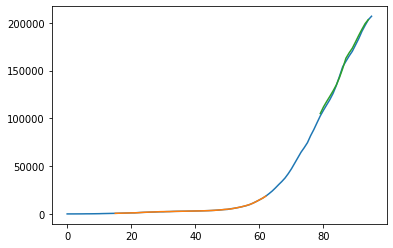

In [35]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_deaths)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_deaths)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_deaths)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_deaths)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [36]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_deaths[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

In [37]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

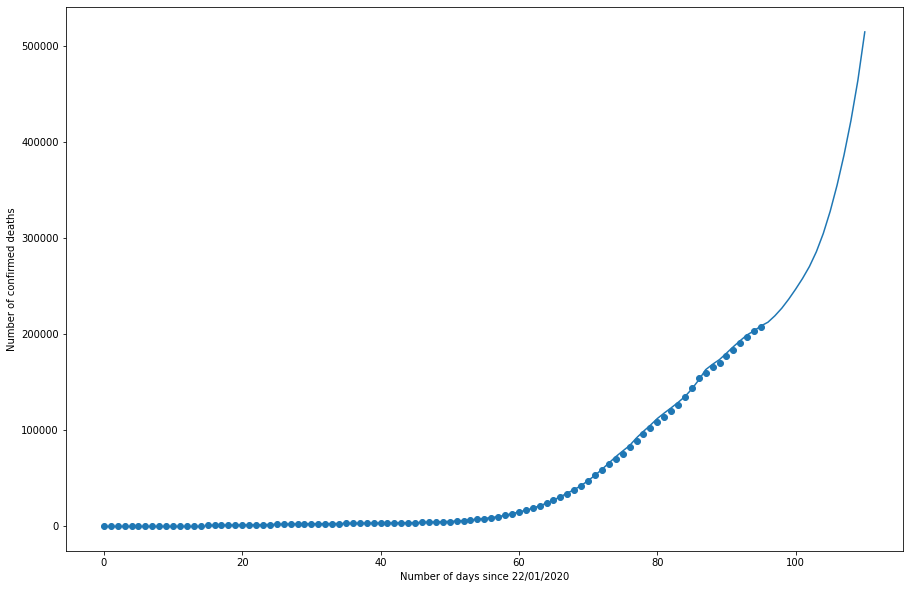

In [38]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed deaths')
plt.plot(allTest)
plt.show()

## Confirmed recoveries

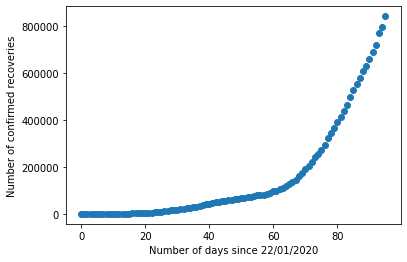

In [39]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed recoveries')
plt.show()

In [40]:
dp_world_recoveries = world_recovered.astype('float32')

In [41]:
# split into train and test sets
train_size = int(len(dp_world_recoveries) * 0.67)
test_size = len(dp_world_recoveries) - train_size
train, test = dp_world_recoveries[0:train_size], dp_world_recoveries[train_size:len(dp_world_deaths)]
print(len(train), len(test))

64 32


In [42]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [43]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_recoveries, look_back)
print(len(trainX))
print(len(testX))
print(len(testX)+len(trainX)+30)
print(len(finalX))
print(len(dp_world_recoveries))

48
16
94
81
96


In [44]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 11450930675.8333
Epoch 2/1000
 - 0s - loss: 7330600488.1667
Epoch 3/1000
 - 0s - loss: 4469398843.2917
Epoch 4/1000
 - 0s - loss: 2625408755.2083
Epoch 5/1000
 - 0s - loss: 1451360523.8333
Epoch 6/1000
 - 0s - loss: 826115300.2917
Epoch 7/1000
 - 0s - loss: 446731001.9167
Epoch 8/1000
 - 0s - loss: 213167685.1146
Epoch 9/1000
 - 0s - loss: 102756720.2083
Epoch 10/1000
 - 0s - loss: 47615589.1250
Epoch 11/1000
 - 0s - loss: 24507600.8568
Epoch 12/1000
 - 0s - loss: 18100268.9557
Epoch 13/1000
 - 0s - loss: 14348730.4899
Epoch 14/1000
 - 0s - loss: 13682953.5911
Epoch 15/1000
 - 0s - loss: 13429342.0098
Epoch 16/1000
 - 0s - loss: 13418126.4546
Epoch 17/1000
 - 0s - loss: 13315985.2443
Epoch 18/1000
 - 0s - loss: 13781507.6198
Epoch 19/1000
 - 0s - loss: 13762784.7005
Epoch 20/1000
 - 0s - loss: 13303509.1246
Epoch 21/1000
 - 0s - loss: 13418039.2865
Epoch 22/1000
 - 0s - loss: 13209864.1771
Epoch 23/1000
 - 0s - loss: 13253512.6432
Epoch 24/1000
 - 0s - loss: 

Epoch 196/1000
 - 0s - loss: 5613717.7305
Epoch 197/1000
 - 0s - loss: 5716874.0768
Epoch 198/1000
 - 0s - loss: 5411947.6445
Epoch 199/1000
 - 0s - loss: 5227904.5156
Epoch 200/1000
 - 0s - loss: 5184987.2109
Epoch 201/1000
 - 0s - loss: 5328908.0781
Epoch 202/1000
 - 0s - loss: 6105939.8684
Epoch 203/1000
 - 0s - loss: 5431572.9085
Epoch 204/1000
 - 0s - loss: 5659288.0579
Epoch 205/1000
 - 0s - loss: 5410865.2542
Epoch 206/1000
 - 0s - loss: 5431050.6074
Epoch 207/1000
 - 0s - loss: 5464254.7904
Epoch 208/1000
 - 0s - loss: 5230778.6790
Epoch 209/1000
 - 0s - loss: 5137228.0482
Epoch 210/1000
 - 0s - loss: 5410456.5744
Epoch 211/1000
 - 0s - loss: 5446589.3945
Epoch 212/1000
 - 0s - loss: 5124536.4427
Epoch 213/1000
 - 0s - loss: 5236558.8272
Epoch 214/1000
 - 0s - loss: 5832777.9023
Epoch 215/1000
 - 0s - loss: 6259661.3438
Epoch 216/1000
 - 0s - loss: 5353060.5625
Epoch 217/1000
 - 0s - loss: 5213290.0827
Epoch 218/1000
 - 0s - loss: 5337700.1016
Epoch 219/1000
 - 0s - loss: 58447

 - 0s - loss: 3053355.1094
Epoch 392/1000
 - 0s - loss: 4978062.1771
Epoch 393/1000
 - 0s - loss: 3323414.9284
Epoch 394/1000
 - 0s - loss: 3295893.2834
Epoch 395/1000
 - 0s - loss: 3601799.9069
Epoch 396/1000
 - 0s - loss: 3675007.2428
Epoch 397/1000
 - 0s - loss: 5089838.0135
Epoch 398/1000
 - 0s - loss: 5414725.2969
Epoch 399/1000
 - 0s - loss: 5861320.0977
Epoch 400/1000
 - 0s - loss: 3803456.4154
Epoch 401/1000
 - 0s - loss: 3772051.7832
Epoch 402/1000
 - 0s - loss: 3672368.6323
Epoch 403/1000
 - 0s - loss: 3197203.5312
Epoch 404/1000
 - 0s - loss: 3373608.7163
Epoch 405/1000
 - 0s - loss: 3443725.7005
Epoch 406/1000
 - 0s - loss: 3039976.1217
Epoch 407/1000
 - 0s - loss: 4126466.7760
Epoch 408/1000
 - 0s - loss: 3839775.7747
Epoch 409/1000
 - 0s - loss: 3638146.4590
Epoch 410/1000
 - 0s - loss: 3628095.3519
Epoch 411/1000
 - 0s - loss: 3186005.0321
Epoch 412/1000
 - 0s - loss: 3596880.8203
Epoch 413/1000
 - 0s - loss: 4238703.9108
Epoch 414/1000
 - 0s - loss: 4275265.0983
Epoch 4

Epoch 587/1000
 - 0s - loss: 1666896.4336
Epoch 588/1000
 - 0s - loss: 1302529.7031
Epoch 589/1000
 - 0s - loss: 3169554.4802
Epoch 590/1000
 - 0s - loss: 4045660.6711
Epoch 591/1000
 - 0s - loss: 1913423.8921
Epoch 592/1000
 - 0s - loss: 1882350.6572
Epoch 593/1000
 - 0s - loss: 1524609.9526
Epoch 594/1000
 - 0s - loss: 1372848.6772
Epoch 595/1000
 - 0s - loss: 1534499.3913
Epoch 596/1000
 - 0s - loss: 1377458.3506
Epoch 597/1000
 - 0s - loss: 1828596.0754
Epoch 598/1000
 - 0s - loss: 2104487.5429
Epoch 599/1000
 - 0s - loss: 2142367.0337
Epoch 600/1000
 - 0s - loss: 1342179.9691
Epoch 601/1000
 - 0s - loss: 1807777.1814
Epoch 602/1000
 - 0s - loss: 1727157.6476
Epoch 603/1000
 - 0s - loss: 4078333.9619
Epoch 604/1000
 - 0s - loss: 3959986.6672
Epoch 605/1000
 - 0s - loss: 2285442.0078
Epoch 606/1000
 - 0s - loss: 1673978.1813
Epoch 607/1000
 - 0s - loss: 1292266.9912
Epoch 608/1000
 - 0s - loss: 1648514.7108
Epoch 609/1000
 - 0s - loss: 2027208.2630
Epoch 610/1000
 - 0s - loss: 20324

 - 0s - loss: 1723570.4622
Epoch 783/1000
 - 0s - loss: 1589558.7689
Epoch 784/1000
 - 0s - loss: 1838143.6759
Epoch 785/1000
 - 0s - loss: 1438914.3874
Epoch 786/1000
 - 0s - loss: 1708253.2946
Epoch 787/1000
 - 0s - loss: 1317591.3512
Epoch 788/1000
 - 0s - loss: 1428628.7288
Epoch 789/1000
 - 0s - loss: 1582564.0488
Epoch 790/1000
 - 0s - loss: 2349545.8320
Epoch 791/1000
 - 0s - loss: 1664905.7825
Epoch 792/1000
 - 0s - loss: 1493059.8356
Epoch 793/1000
 - 0s - loss: 1906778.8477
Epoch 794/1000
 - 0s - loss: 1326078.2082
Epoch 795/1000
 - 0s - loss: 1858027.2858
Epoch 796/1000
 - 0s - loss: 1951742.4098
Epoch 797/1000
 - 0s - loss: 4024634.1401
Epoch 798/1000
 - 0s - loss: 2172551.7406
Epoch 799/1000
 - 0s - loss: 1502016.5451
Epoch 800/1000
 - 0s - loss: 1438498.5566
Epoch 801/1000
 - 0s - loss: 1583173.7126
Epoch 802/1000
 - 0s - loss: 1636813.2760
Epoch 803/1000
 - 0s - loss: 2862075.7646
Epoch 804/1000
 - 0s - loss: 1229109.5921
Epoch 805/1000
 - 0s - loss: 1814727.0322
Epoch 8

Epoch 978/1000
 - 0s - loss: 1470530.5967
Epoch 979/1000
 - 0s - loss: 1071853.4964
Epoch 980/1000
 - 0s - loss: 1965632.1842
Epoch 981/1000
 - 0s - loss: 1367353.2507
Epoch 982/1000
 - 0s - loss: 1598301.0020
Epoch 983/1000
 - 0s - loss: 1821250.0049
Epoch 984/1000
 - 0s - loss: 1608198.0244
Epoch 985/1000
 - 0s - loss: 1396480.7204
Epoch 986/1000
 - 0s - loss: 2294321.8618
Epoch 987/1000
 - 0s - loss: 1386833.9263
Epoch 988/1000
 - 0s - loss: 2014038.7741
Epoch 989/1000
 - 0s - loss: 1624809.4909
Epoch 990/1000
 - 0s - loss: 2272442.7458
Epoch 991/1000
 - 0s - loss: 2828466.6865
Epoch 992/1000
 - 0s - loss: 1625924.7367
Epoch 993/1000
 - 0s - loss: 2077044.8315
Epoch 994/1000
 - 0s - loss: 1464462.5926
Epoch 995/1000
 - 0s - loss: 1407456.6357
Epoch 996/1000
 - 0s - loss: 1397205.8540
Epoch 997/1000
 - 0s - loss: 1274006.5999
Epoch 998/1000
 - 0s - loss: 1417092.3772
Epoch 999/1000
 - 0s - loss: 1400365.9148
Epoch 1000/1000
 - 0s - loss: 1633836.1314


In [45]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 2573356.00 MSE (1604.17 RMSE)
Test Score: 894625408.00 MSE (29910.29 RMSE)


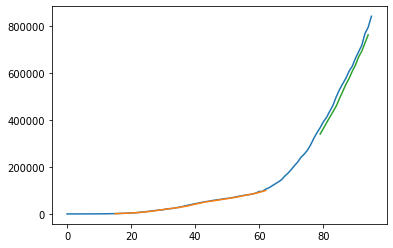

In [47]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_recoveries)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_recoveries)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_recoveries)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_recoveries)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:










testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_recoveries)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed recoveries')
plt.plot(allTest)

Train Score: 20925.72 MSE (144.66 RMSE)
Test Score: 7315683.00 MSE (2704.75 RMSE)


NameError: name 'numpy' is not defined